In [1]:
import numpy as np
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel  
from typing import List, Union, Dict, Tuple
from scipy.spatial.distance import cosine
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")  
model = AutoModel.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext").to(device)

In [2]:
def generate_embedding_map(all_names: List[str], bs: int = 128) -> Dict[str, np.ndarray]:
    all_embs = {}  # Initialize the dictionary for embeddings

    for i in tqdm(range(0, len(all_names), bs)):
        # Tokenize batch
        toks = tokenizer.batch_encode_plus(
            all_names[i:i + bs],
            padding="max_length",
            max_length=25,
            truncation=True,
            return_tensors="pt"
        )
        
        toks_device = {k: v.to(device) for k, v in toks.items()}
        
        cls_rep = model(**toks_device)[0][:, 0, :]
        
        np_embeddings = cls_rep.cpu().detach().numpy()
        for name, embedding in zip(all_names[i:i + bs], np_embeddings):
            all_embs[name] = embedding
    
    return all_embs

def get_cos_sim(embed1, embed2):
    e1_norm = embed1 / np.linalg.norm(embed1)
    e2_norm = embed2 / np.linalg.norm(embed2)
    return np.dot(e1_norm, e2_norm)
    
def closest_embedding(root_s: str, s_to_embed: Dict[str, np.ndarray]) -> Tuple[str, np.ndarray]:
    root_embed = s_to_embed[root_s]
    
    closest_str = None
    closest_embedding = None
    max_similarity = -1  

    for string, embed in s_to_embed.items():
        if string == root_s:
            continue  

        similarity = get_cos_sim(root_embed, embed)

        if similarity > max_similarity:
            max_similarity = similarity
            closest_str = string
            closest_embedding = embed

    return closest_str, closest_embedding

In [3]:
class Node:
    def __init__(self, name: str = "", _type: str = "", embedding: np.ndarray = None):
        self.name = name
        self._type = _type
        self.embed = embedding if embedding is not None else np.zeros(768)
        self.connections = {} 

    def connect(self, other: 'Node', strength: float):
        self.connections[other] = strength
        other.connections[self] = strength

    def __repr__(self):
        connections_info = {node.name: strength for node, strength in self.connections.items()}
        return f"Node: {self.name}, Type: {self._type}, connections: {connections_info}"


class KN:
    def __init__(self, nodes: List[Node] = None, threshold: float = 0.5):
        self.nodes = nodes if nodes is not None else []
        self.threshold = threshold
        self.connect_all_nodes()

    def add_node(self, node: Node):
        for existing_node in self.nodes:
            strength = get_cos_sim(node.embed, existing_node.embed)
            node.connect(existing_node, strength)
        self.nodes.append(node)

    def connect_all_nodes(self):
        for i, node in enumerate(self.nodes):
            for j in range(i + 1, len(self.nodes)):
                strength = get_cos_sim(node.embed, self.nodes[j].embed)
                node.connect(self.nodes[j], strength)

    def display_connections(self):
        for node in self.nodes:
            connections = {connected_node.name: round(strength, 2) for connected_node, strength in node.connections.items()}
            print(f"Node {node.name} connections: {connections}")

    def display_graphically(self):
        import networkx as nx
        import matplotlib.pyplot as plt
    
        G = nx.Graph()
    
        for node in self.nodes:
            G.add_node(node.name, label=node._type)
    
        for node in self.nodes:
            for connected_node, strength in node.connections.items():
                G.add_edge(node.name, connected_node.name, weight=strength)
    
        edges = G.edges(data=True)
        edge_colors = ["green" if attr["weight"] > self.threshold else "gray" for _, _, attr in edges]
        edge_weights = [attr["weight"] * 2 for _, _, attr in edges]
    
        pos = nx.spring_layout(G, weight='weight', scale=2, seed=42)
    
        plt.figure(figsize=(12, 8))
    
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue")
        nx.draw_networkx_labels(G, pos, font_size=10)
    
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_weights)
    
        green_patch = plt.Line2D([0], [0], color="green", lw=2, label="Strong Connection")
        gray_patch = plt.Line2D([0], [0], color="gray", lw=2, label="Weak Connection")
        plt.legend(handles=[green_patch, gray_patch])
    
        plt.title("Knowledge Network Graph with Connection Strengths")
        plt.show()

In [4]:
def create_KN(all_names: List["str"]):
    _dict = generate_embedding_map(all_names)
    nodes = [Node(string, "", embed) for string, embed in _dict.items()]
    _KN = KN(nodes)
    return _KN

In [5]:
all_names = ["covid-19", "Coronavirus infection", "high fever", "Tumor of posterior wall of oropharynx"] 
temp_KN = create_KN(all_names)

  0%|          | 0/1 [00:00<?, ?it/s]

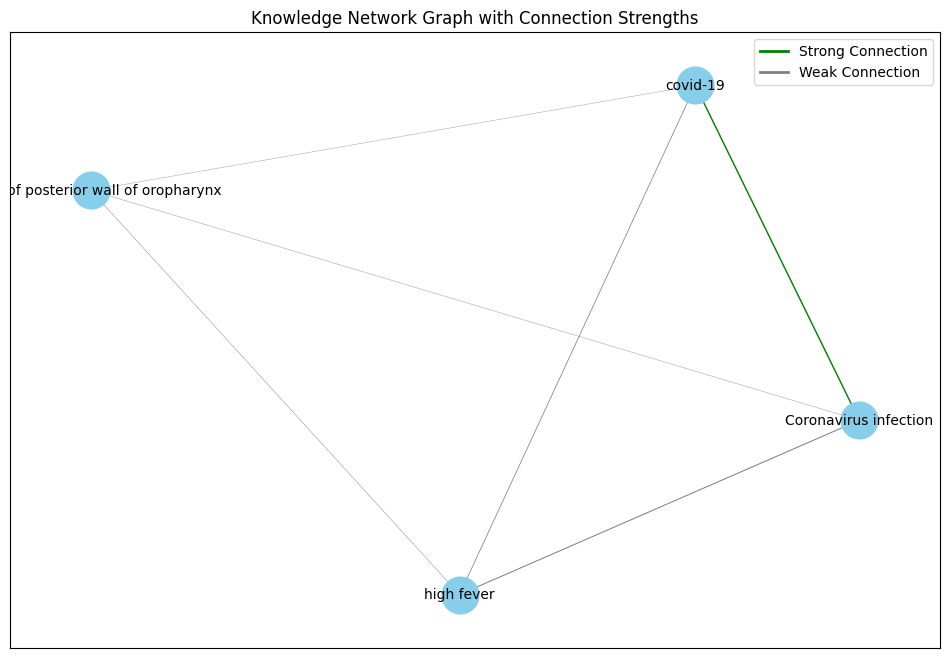

In [7]:
temp_KN.display_graphically()